In [232]:
#génération du graphe
nbIndividus = 1000 # nombre d'individus dans le graphe
deg_moy = 100 #le nombre moyen de connexion par personne
household_size = 6 #la taille moyenne d'un foyer
household_proba = 1 #la probabilité de contact par jour entre membre d'un même foyer
extern_contact_proba = 0.3 #la probabilité de contact par jour entre personne de foyers différents

UtilAppli = 0.8 #la proportion d'utilisateurs de l'application dans la population générale
InitSain = 0.99 #la proportion de personnes saines à l'intant initial (les autres sont porteurs assymptomatiques)

# application
joursNotif = 14

pDetection = 0.9
pSignalement = 0.9
pQNotif = 0.8 # proba de mise en confinement lors de la réception d'une notif

# probas initialisation
rencontreFoyer = 0.9 # proba de rencontrer un autre membre du foyer
rencontreCommunaute = 0.01 # proba de rencontrer un autre membre de la communauté
rencontreNational = 0.001

# probas
pContamination = 0.02 # proba de contaminer un autre individu

pAtoG = 0.07 # proba de passer de asymptotique à guéri
pAtoIS = 0.02 # passage de asymptotique à avec symptomes
pAtoD = 0.0001 # proba de décès

pIStoG = 0.07 # avec symptomes à gueri
pIStoD = 0.01

pQSymptomes = 0.9 # proba confinement lors de détection symptomes

facteurConfinement = 100 # Réduction des probas de rencontre lors du confinement
jourConfinement = 14

nbMaladeS = 0
nbMaladeAS = 0
nbSain = 0
nbDecede = 0
nbGueri = 0
nbQuarantaine = 0

In [233]:
# Librairies
import random
import math as m

In [234]:
SAIN=0
MALADEASYMP=1
MALADE=2
GUERI=3
DECEDE=4

In [235]:
individus = []
adj = []

In [236]:
# Initialisation du graphe

def init_graphe():
    global nbSain
    global nbMaladeAS
    global individus
    global adj
    
    individus = []
    adj = []

    for i in range(nbIndividus):
        app = False
        if random.uniform(0,1) < UtilAppli:
            app =True

        s = MALADEASYMP
        if random.uniform(0,1) < InitSain:
            s = SAIN
            nbSain +=1
        else:
            nbMaladeAS +=1

        individus.append({"state": s, "confine": False, "resteConfinement": 0, "appli": app})

    def get_matching(u, distrib):
        a =0
        b = len(distrib)-1
        if (u> distrib[b]):
            return b
        else:

            while (b-a > 1):
                m = (a+b)//2

                if distrib[m] > u:
                    b= m
                else:
                    a=m
            m = (a+b)//2

            if distrib[m] > u:
                return a +1
            else:
                return b+1

    def somme(l):
        s = 0
        for x in l:
            s +=x
        return s

    def not_empty(l):
        for x in l:
            if x> 0:
                return True
        return False


    def get_ind(x, degrees):
        s = 0
        for i in range(len(degrees)):
            s += degrees[i]
            if x <=s:
                return i



    def random_pair(S, degrees):
        x1 = random.randint(1,S)
        x2 = random.randint(1,S)

        ind1 = get_ind(x1, degrees)
        ind2 = get_ind(x2, degrees)
        return ind1, ind2





    distrib = [1- m.exp(-1/deg_moy)] #for k = 0


    degrees = []

    for k in range(1,100):
        p = (1- m.exp(-1/deg_moy))* m.exp(-k/deg_moy)
        distrib.append(distrib[k-1]+p)

    for i in range(nbIndividus):
        u = random.uniform(0,1)
        deg = get_matching(u, distrib)
        degrees.append(deg)

    #to get an even number of total degrees
    save_deg = degrees[:]

    S = somme(degrees)
    if S%2 == 1:
        degrees[0] +=1

    for i in range(nbIndividus):
        adj.append([])


    while S>0:
        p1, p2 = random_pair(S, degrees)
        if degrees[p1] <= household_size or degrees[p2] <= household_size:
            adj[p1].append({"noeud" : p2, "proba" : household_proba})
            adj[p2].append({"noeud" : p1, "proba" : household_proba})
        else:
            adj[p1].append({"noeud" : p2, "proba" : extern_contact_proba})
            adj[p2].append({"noeud" : p1, "proba" : extern_contact_proba})
        degrees[p1] -= 1
        degrees[p2] -= 1
        S -= 2

# Fonctions de gestion du graphe

In [237]:
rencontres = [[[] for jour in range(joursNotif)] for individu in range(nbIndividus)]

In [238]:
def contamination(i, j):
    global nbSain
    global nbMaladeAS
    global individus
    if individus[i]['state'] == individus[j]['state']:
        return
    if individus[i]['state'] >= GUERI or individus[j]['state'] >= GUERI:
        return # on ne peut pas contaminer les individus guéris ou décédés
    
    if individus[i]['state'] == SAIN:
        contamination(j, i)
        
        return
    
    if individus[j]['state'] != SAIN or random.random() > pContamination:
        return # pas contamination

    nbSain -= 1
    nbMaladeAS += 1
    individus[j]['state'] = MALADEASYMP

In [239]:
# Passage au jour suivant du graphe
def step():
    global nbSain
    global nbMaladeS
    global nbMaladeAS
    global nbDecede
    global nbGueri
    global nbQuarantaine
    
    for rencontre in rencontres:
        rencontre.append([]) # contiendra les nouvelles rencontres du jour

    # On constate toutes les rencontres entre individus
    for i in range(nbIndividus):
        for arete in adj[i]:
            j = arete['noeud']
            if j < i:
                continue # on ne regarde qu'un sens de chaque arête
            
            facteur = 1
            if individus[i]['resteConfinement'] > 0:
                facteur *= facteurConfinement
            if individus[j]['resteConfinement'] > 0:
                facteur *= facteurConfinement
                
            if random.random() > arete['proba'] / facteur: # Si i et/ou j sont confinés, réduction de leur proba de rencontre
                continue # pas de rencontre
        
            # Si i et j ont l'appli, on note la rencontre
            if individus[i]['appli'] and individus[j]['appli'] and random.random() < pDetection: 
                rencontres[i][-1].append(j) 
                rencontres[j][-1].append(i)
            
            contamination(i, j)
    
    # On passe au jour suivant
    nbQuarantaine = 0
    for i in range(nbIndividus):
        individus[i]['resteConfinement'] -= 1
        if individus[i]['resteConfinement'] > 0:
            nbQuarantaine +=1

    for i, individu in enumerate(individus): # On met à jour les états des individus
        if individu['state'] == MALADEASYMP:
            action = random.random()
            if action < pAtoG:
                nbMaladeAS -= 1
                nbGueri += 1
                individu['state'] = GUERI
            elif action > 1 - pAtoIS:
                nbMaladeAS -= 1
                nbMaladeS += 1
                individu['state'] = MALADE
                
                # envoi des notifs (rencontres[i] vide si i n'a pas l'appli)
                for jourRencontre in rencontres[i]:
                    for contact in jourRencontre:
                        if random.random() < pQNotif:
                            individus[contact]['resteConfinement'] = jourConfinement
                
                if random.random() < pQSymptomes: # mise en confinement à la détection des symptomes
                    individu['resteConfinement'] = jourConfinement
                
        elif individu['state'] == MALADE:
            action = random.random()
            if action < pIStoG:
                nbMaladeS -= 1
                nbGueri += 1
                individu['state'] = GUERI
            elif action > 1 - pIStoD:
                nbMaladeS -= 1
                nbDecede += 1
                individu['state'] = DECEDE
    
    # On supprime le plus vieux jour de l'historique
    for rencontre in rencontres:
        rencontre.pop(0)
        
            

# Affichage

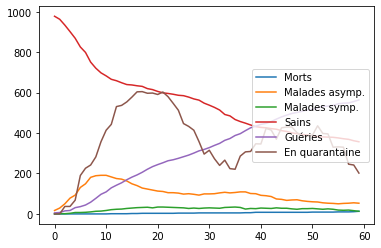

In [240]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

init_graphe()

fig = plt.figure()
ax = fig.add_subplot()
xs = []
y_D = []
y_MS = []
y_MAS = []
y_S = []
y_G = []
y_Q = []

def update_viz():
    xs.append(len(xs))
    y_D.append(nbDecede)        # ajoute le nombre de decedes
    y_MS.append(nbMaladeS)      # ajoute le nombre de malade symptomatiques
    y_MAS.append(nbMaladeAS)    # ajoute le nombre de malade asymptomatiques
    y_S.append(nbSain)          # ajoute le nombre de personnes saines
    y_G.append(nbGueri)         # ajoute le nombre de personnes guéries
    y_Q.append(nbQuarantaine)   # ajoute le nombre de personnes en quarantaine
    
def draw_viz():
    ax.clear()
    def plot_with_label(ys, label):
        line, = ax.plot(xs, ys)
        line.set_label(label)
    plot_with_label(y_D, "Morts")
    plot_with_label(y_MAS, "Malades asymp.")
    plot_with_label(y_MS, "Malades symp.")
    plot_with_label(y_S, "Sains")
    plot_with_label(y_G, "Guéries")
    plot_with_label(y_Q, "En quarantaine")

    ax.legend(loc='right')

nbSteps = 60
for _ in range(nbSteps):
    # update simulation
    step()
    # update matplotlib
    update_viz()
draw_viz()